In [3]:
# -*- coding: urf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import requests 
from bs4 import BeautifulSoup
import re

In [4]:
# 크롤링할 사이트 주소를 정의합니다.
source_url = "https://namu.wiki/RecentChanges"

# 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
req = requests.get(source_url)
html = req.content
soup = BeautifulSoup(html, 'lxml')
contents_table = soup.find(name="table")
table_body = contents_table.find(name="tbody")
table_rows = table_body.find_all(name="tr")

# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성합니다.
page_url_base = "https://namu.wiki"
page_urls = []
for index in range(0, len(table_rows)):
    first_td = table_rows[index].find_all('td')[0]
    td_url = first_td.find_all('a')
    if len(td_url) > 0:
        page_url = page_url_base + td_url[0].get('href')
        if 'png' not in page_url:
            page_urls.append(page_url)
            
# 중복 url을 제거합니다.
page_urls = list(set(page_urls))
for page in page_urls[:5]:
    print(page)

https://namu.wiki/w/%EB%A3%A8%EC%8B%9C%EB%93%9C%20%EB%93%9C%EB%A6%BC
https://namu.wiki/w/%EA%B0%9C%EC%84%A4%EB%B0%A9%EC%96%B4
https://namu.wiki/w/PANG
https://namu.wiki/w/2020%EB%85%84%20%ED%83%9C%EA%B5%AD%20%EB%AF%BC%EC%A3%BC%ED%99%94%20%EC%9A%B4%EB%8F%99
https://namu.wiki/w/%EA%B0%95%EB%B3%91%EA%B7%A0


In [5]:
# 크롤링한 데이터를 데이터 프레임으로 만들기 위해 준비합니다.
columns = ['title', 'category', 'content_text']
df = pd.DataFrame(columns=columns)

# 각 페이지별 '제목', '카테고리', '본문' 정보를 데이터 프레임으로 만듭니다.
for page_url in page_urls:

    # 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
    req = requests.get(page_url)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    contents_table = soup.find(name="article")
    title = contents_table.find_all('h1')[0]
    
    # 카테고리 정보가 없는 경우를 확인합니다.
    if len(contents_table.find_all('ul')) > 0:
        category = contents_table.find_all('ul')[0]
    else:
        category = None
    content_paragraphs = contents_table.find_all(name="div", attrs={"class":"wiki-paragraph"})
    content_corpus_list = []
    
    # 페이지 내 제목 정보에서 개행 문자를 제거한 뒤 추출합니다.
    # 만약 없는 경우, 빈 문자열로 대체합니다.
    if title is not None:
        row_title = title.text.replace("\n"," ")
    else:
        row_title = ""
        
    # 페이지 내 본문 정보에서 개행 문자를 제거한 뒤 추출합니다.
    # 만약 없는 경우, 빈 문자열로 대체합니다.
    if content_paragraphs is not None:
        for paragraphs in content_paragraphs:
            if paragraphs is not None:
                # replace("찾을값", "바꿀값", [바꿀횟수])
                content_corpus_list.append(paragraphs.text.replace("\n", " "))
            else:
                content_corpus_list.append("")
    else:
        content_corpus_list.append("")
        
    # 페이지 내 카테고리정보에서 "분류"라는 단어와 개행 문자를 제거한 뒤 추출합니다.
    # 만약 없는 경우, 빈 문자열로 대체합니다.
    if category is not None:
        row_category = category.text.replace("\n", " ")
    else:
        row_category = ""
    
    # 모든 정보를 하나의 데이터 프레임에 저장합니다.
    # "문자".join() 리스트에 특정 구분자를 추가하여 문자열로 변환함
    row = [row_title, row_category, "".join(content_corpus_list)]
    series = pd.Series(row, index = df.columns)
    df = df.append(series, ignore_index=True)

In [6]:
# 데이터 프레임을 출력합니다.
df.head(5)

,title,category,content_text
0,루시드 드림,동음이의어/ㄹ영어 단어,1. 자각몽(Lucid Dream)2. 작품 이름2.1. 웹툰 루시드 드림2.2. ...
1,개설방어,금융,1. 개요2. 개설방어를 하는곳3. 폐해4. 기존 차명계좌들은?5. 여담6. 해외의...
2,PANG,항공모함,"현대의 프랑스 해군 군함 [ 펼치기 · 접기 ]잠수함재래식아레튀즈급R, 다프네급..."
3,2020년 태국 민주화 운동,2020년 시위태국의 사건사고민주화 운동2020년/사건사고,2020년 9월 20일 방콕의 사남루앙(สนามหลวง) 광장에서 개최된 시위...
4,강병균,포항공과대학교 재직이학 교수수학자종교학자,1. 개요2. 반불교3. 비판4. 저서대한민국의 수학자 겸 대학 교수. 서울대학교에...


In [7]:
# 텍스트 정제 함수: 한글 이외의 문자는 전부 제거합니다.
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+') # 한글의 정규 표현식을 나타냅니다.
    result = hangul.sub('', text)
    return result

print(text_cleaning(df['content_text'][0]))

 자각몽  작품 이름 웹툰 루시드 드림 영화 루시드 드림  의 곡   자세한 내용은 자각몽 문서를의 번째 문단을의  부분을 참고하십시오 자세한 내용은 루시드 드림웹툰 문서를의 번째 문단을의  부분을 참고하십시오김준성 감독의 범죄 스릴러 영화로 년 개봉 예정이었으나 년 들어서도 개봉 소식이 없으며 주연 중 박유천이 있는 바람에 개봉 여부가 매우 불투명해졌다가 그 와중 네이버 영화에선연관 영화 주목 결국 년 월 일 개봉했다 자세한 내용은 루시드 드림영화 문서를의 번째 문단을의  부분을 참고하십시오  문서 참조 년 음악 시장 전체를 통틀어 그를 가장 핫한 루키로 만들어 준 노래이다


In [8]:
# 각 피처마다 데이터 전처리를 적용합니다.
df['title'] = df['title'].apply(lambda x : text_cleaning(x))
df['category'] = df['category'].apply(lambda x : text_cleaning(x))
df['content_text'] = df['content_text'].apply(lambda x : text_cleaning(x))
df.head(5)

,title,category,content_text
0,루시드 드림,동음이의어ㄹ영어 단어,자각몽 작품 이름 웹툰 루시드 드림 영화 루시드 드림 의 곡 자세한 내용은...
1,개설방어,금융,개요 개설방어를 하는곳 폐해 기존 차명계좌들은 여담 해외의 개설방어 홍콩 일본 중...
2,,항공모함,현대의 프랑스 해군 군함 펼치기 접기 잠수함재래식아레튀즈급 다프네급 아고스타...
3,년 태국 민주화 운동,년 시위태국의 사건사고민주화 운동년사건사고,년 월 일 방콕의 사남루앙 광장에서 개최된 시위에서 학생 지도자들이 태국은 한...
4,강병균,포항공과대학교 재직이학 교수수학자종교학자,개요 반불교 비판 저서대한민국의 수학자 겸 대학 교수 서울대학교에서 수학으로 학사...


In [9]:
# 각 피처마다 말뭉치를 생성합니다.
title_corpus = "".join(df['title'].tolist())
category_corpus = "".join(df['category'].tolist())
content_corpus = "".join(df['content_text'].tolist())
print(title_corpus)

루시드 드림 개설방어  년 태국 민주화 운동 강병균 경인고등학교 울프 링크 철구인터넷 방송인논란 및 사건사고년년 몬스터 슈퍼리그 한국 고양이 꼬등어 극장판 쿠드 와후타    모드      국가유럽 방역 천주교 부산교구 이용우 피에르에메릭 오바메양 원불교 파일유창현 한화생명 다시 한번 이지현 히에이유유백서 새벽공방음반 목록 사쿠라 아야네 릴보이 노무현긍정적 평가 동물의 숲 시리즈일반 주민말 에코리그 오브 레전드 충리그 오브 레전드 아오야마 블루마운틴 쾌도천사 트윈엔젤 기아 버스 인천해역방어사령부 자료실 스와베 준이치 나무위치 문서작성 미나세 이노리 세렌 니시타니 호마레 네오시티  포켓몬스터 마왕성에서 잘 자요등장인물 걸그룹 어느 수학자가 본 기이한 세상 겐다 텟쇼 유치원지역별 현황영남권   고양시역사   발매 전후 정보 아스카가와 치세 나의 히어로 아카데미아비판 메이플스토리 백식관음 이담향 허준드라마등장인물 프린세스 메이커 엔딩 고양이귀 소울 나이트무기부속물 제작 무기 년 월드 시리즈 리처드 하우랜드 아카라이브 카타르외교 카운터사이드도감 이숭용 아이리스 나자 에리스이스 야마네 마사시 영원한 일의 도시 목록 차명석프런트 경력 우석만 보겸 소우마 코이치 소녀주의보 문지애 행정구역 개편수도권인천개편론 틀현대자동차그룹         분류킹스턴캐나다 출신 인물  레전드 라이트하이라이트 스기타 토모카즈 시모노 히로 


In [10]:
!pip install konlpy==0.5.1
!pip install jpype1
!pip install Jpype1-py3

In [11]:
from konlpy.tag import Okt
from collections import Counter

# konply의 형태소 분석기로 명사 단위의 키워드를 추출합니다. 
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)

In [12]:
count

Counter({'자각몽': 2,
         '작품': 134,
         '이름': 360,
         '웹툰': 12,
         '루': 43,
         '시드': 9,
         '드림': 9,
         '영화': 52,
         '의': 608,
         '곡': 281,
         '내용': 379,
         '를': 345,
         '문단': 1489,
         '부분': 298,
         '참고': 183,
         '김준성': 1,
         '감독': 92,
         '범죄': 23,
         '스릴러': 1,
         '영화로': 1,
         '년': 1893,
         '개봉': 16,
         '예정': 72,
         '소식': 44,
         '주연': 24,
         '중': 931,
         '박유천': 1,
         '바람': 91,
         '여부': 20,
         '매우': 281,
         '그': 1482,
         '와중': 34,
         '네이버': 25,
         '연관': 24,
         '주목': 35,
         '월': 1241,
         '일': 1373,
         '문서': 1502,
         '참조': 50,
         '음악': 148,
         '시장': 86,
         '전체': 145,
         '통틀어': 11,
         '가장': 326,
         '핫': 6,
         '루키': 2,
         '준': 124,
         '노래': 172,
         '개요': 60,
         '개설': 153,
         '방어': 117,
         '곳': 3

In [13]:
# 한 글자 키워드를 제거합니다.
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

Counter({'문서': 1502, '문단': 1489, '이전': 1458, '역사': 1360, '경우': 1098, '자신': 1084, '엔딩': 1000, '이후': 906, '때문': 898, '토론': 846, '합의': 816, '사항': 798, '유치원': 767, '상태': 752, '한국': 648, '사람': 646, '정도': 634, '이상': 602, '허준': 599, '게임': 597, '공주': 572, '다른': 569, '하나': 565, '왕자': 541, '생각': 484, '시간': 475, '모습': 459, '현재': 450, '에코': 450, '대한': 438, '등장': 438, '방송': 428, '성우': 421, '캐릭터': 418, '사쿠라': 418, '아버지': 409, '시작': 397, '국가': 397, '사실': 391, '지역': 389, '또한': 387, '내용': 379, '사용': 372, '우즈': 365, '고양이': 362, '이름': 360, '위해': 348, '시리즈': 344, '시즌': 338, '가장': 326, '라디오': 323, '상황': 321, '요정': 321, '평가': 319, '친구': 318, '포켓몬': 317, '당시': 316, '관련': 312, '문제': 310, '공격': 309, '다년': 301, '다음': 300, '프린세스': 299, '부분': 298, '다시': 296, '언급': 295, '마왕': 294, '모두': 292, '진행': 291, '이유': 289, '장군': 288, '해당': 285, '이벤트': 284, '매우': 281, '지금': 279, '반응': 278, '추가': 264, '세계': 262, '본인': 258, '대해': 257, '모든': 256, '인간': 254, '포켓몬스터': 252, '매력': 252, '라며': 249, '역시': 245, '가지': 245, '일본': 243, '능

In [14]:
# 한국어 약식 불용어 사전 예시 파일을 적용합니다.
korean_stopwords_path = "../data/korean_stopwords.txt"

# 텍스트 파일을 오픈합니다.
with open(korean_stopwords_path, encoding='utf8') as f:
    # readlines()로 파일을 읽으면 한 줄, 한 줄이 각각 리스트의 원소로 들어갑니다.
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
print(stopwords[:10])    

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


In [15]:
# 나무위키 페이지에 맞는 불용어를 추가합니다.
namu_wiki_stopwords = ['상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가', '모든', '사용', '매우', '가장',
                       '줄거리', '요소', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물', 
                       '이름', '년월']
for stopword in namu_wiki_stopwords:
    stopwords.append(stopword)
    
# 키워드 데이터에서 불용어를 제거합니다.
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})
print(remove_char_counter)

Counter({'문단': 1489, '이전': 1458, '역사': 1360, '엔딩': 1000, '토론': 846, '합의': 816, '사항': 798, '유치원': 767, '상태': 752, '한국': 648, '사람': 646, '허준': 599, '게임': 597, '공주': 572, '왕자': 541, '현재': 450, '에코': 450, '대한': 438, '등장': 438, '방송': 428, '성우': 421, '캐릭터': 418, '사쿠라': 418, '아버지': 409, '시작': 397, '국가': 397, '지역': 389, '우즈': 365, '고양이': 362, '위해': 348, '시리즈': 344, '시즌': 338, '라디오': 323, '요정': 321, '평가': 319, '친구': 318, '포켓몬': 317, '당시': 316, '관련': 312, '문제': 310, '공격': 309, '다년': 301, '프린세스': 299, '부분': 298, '다시': 296, '언급': 295, '마왕': 294, '진행': 291, '이유': 289, '장군': 288, '이벤트': 284, '지금': 279, '반응': 278, '세계': 262, '본인': 258, '대해': 257, '인간': 254, '포켓몬스터': 252, '매력': 252, '라며': 249, '역시': 245, '가지': 245, '일본': 243, '능력': 242, '이야기': 238, '편이': 237, '존재': 234, '처음': 230, '통해': 230, '코로나': 230, '관계': 229, '스킬': 228, '획득': 226, '출연': 225, '학교': 222, '상대': 220, '최초': 220, '아르바이트': 214, '몬스터': 214, '기록': 212, '선택': 210, '조건': 209, '정부': 209, '독일': 209, '발언': 209, '활동': 208, '여왕': 207, '보고': 204,

In [16]:
import random
import pytagcloud
import webbrowser

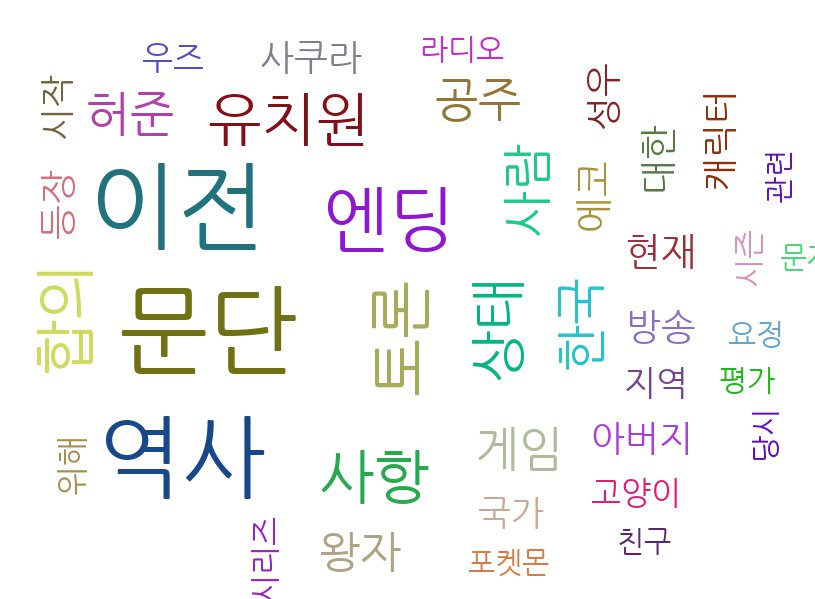

In [17]:
# 가장 출현 빈도수가 높은 40개의 단어를 선정합니다.
ranked_tags = remove_char_counter.most_common(40)

# pytagcloud로 출력할 40개의 단어를 입력합니다. 단어 출력의 최대 크기는80으로 제한합니다.
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)

# pytagcloud 이미지를 생성합니다. 폰트는 나눔 고딕을 사용합니다.
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900,600),
                            fontname='NanumGothic', rectangular=False)

# 생성한 이미지를 주피터 노트북상에서 출력합니다.
from IPython.display import Image
Image(filename='wordcloud.jpg')